# Score Matching Introduction

Let $\mathcal{D}$ be a distribution over $\mathbb{R}^n$ with probability density function (PDF) $p: \mathbb{R}^n \to \mathbb{R}$. One way of modeling $\mathcal{D}$ is via its score function $s: \mathbb{R}^n \to \mathbb{R}^n$ defined as
$$ s(z) = \nabla_z \log p(z)$$

In practice, we may have access to $\mathcal{D}$ via a finite set of samples and don't know its PDF or score function. One simple way to produce a PDF from a discrete set of samples is via radial basis function (RBF) interpolation. For $\sigma \in \mathbb{R}^+$ define the RBF kernel as
$$ K_{\sigma}(x,z) = \textrm{exp}\left(\frac{-\lVert x-z\rVert_2^2}{2\sigma^2}\right)$$

Then the interpolated score function $s_\sigma$ for $\mathcal{D}$ is
$$ s_\sigma(z, \mathcal{D}) = \frac{\mathbb{E}_{x \sim \mathcal{D}}\left[(x-z)K_{\sigma}(x,z)\right]}{\mathbb{E}_{x \sim \mathcal{D}}\left[K_{\sigma}(x,z)\right]}$$

Given a dataset $\mathcal{D}$, the interpolated score function defines a vector field describing a soft projection of arbitrary vectors onto $\mathcal{D}$.

## Task 1: compute and display interpolated score function for a dataset

We define a simple distribution over $\mathbb{R}^2$ - uniform over a spiral - and we sample 20 points from the distribution. The task is to generate a grid of points in $\mathbb{R}^2$ and compute the interpolated score function at each point. Then call the provided plotting code to recreate the following figure:




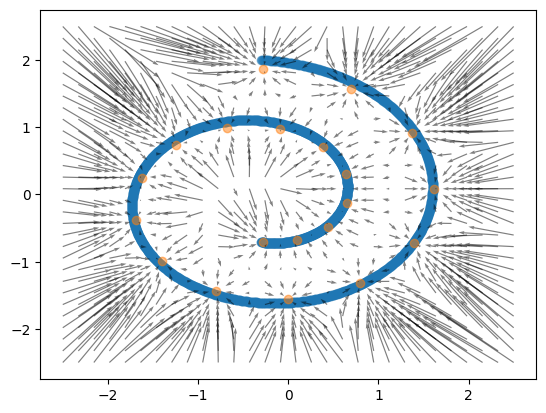


Implement the following functions:


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
# dataset generator
def spiral2d(N=100, random = False, shift=None):
    """Samples N points from a spiral centered at `shift` (or the origin if `shift` is None)"""
    time_steps = torch.rand(N) if random else torch.linspace(0, 1, N)
    t = (3 * torch.pi / 2) * (1 + 2 * time_steps)
    data = torch.stack(
        [t * torch.cos(t), t * torch.sin(t)], dim=1
    )

    data = (data - data.mean(dim=0, keepdims=True)) / data.std(dim=0, keepdims=True)

    # throw the data in a some arbitrary direction
    if shift is not None:
        data = data +  shift

    return data

# plotting helper function
def plot_vectors(z, score, **quiver_kwargs):
    """Plots vector field given by direction vectors `score` at points `z` of R^2"""
    all_lims = torch.stack((z.min(0).values, z.max(0).values, (z+score).min(0).values, (z+score).max(0).values), dim=0)
    mins = all_lims.min(0).values
    maxs = all_lims.max(0).values

    x, y = z.T
    score_x, score_y = score.T
    qargs = dict(angles='xy', scale_units='xy', scale=1, alpha=0.5)
    qargs.update(quiver_kwargs)
    plt.quiver(x, y, score_x, score_y, **qargs)

# generate and plot spiral data
true_dist = spiral2d(N=2000)
dataset = spiral2d(N=20)

In [3]:
import math
import numpy as np
import torch

def get_grid(x_lim=(-2.5,2.5), y_lim=(-2.5,2.5), nx=100, ny=100):
  """Produces an even grid of nx by ny points in R^2,
  from x_lim[0] to x_lim[1] along x axis, and y_lim[0] to y_lim[1] along y axis

  Returns tensor of shape (nx*ny, 2)
  """
  r = []
  for x in np.linspace(x_lim[0], x_lim[1], nx):
    for y in np.linspace(y_lim[0], y_lim[1], ny):
      r.append([x,y])
  return torch.tensor(r)


def rbf_score(z, data, sigma=0.2):
    """ Estimates the interpolated score function for data against inputs z
    
    Params:
    z: a tensor of shape (...,2) giving inputs to the score function
    data: a tensor of shape (N,2) giving the dataset whose interpolated score function we estimate
    sigma: the parameter of the RBF kernel
    
    Returns:
    a tensor of the same shape as z giving the interpolated score function evaluated at z
    """
    x = data
    z.shape # (1000,2)
    x.shape # (20,2)
    diff = x[:,None,:] - z # (10000,20,2)
    sq_dist = (diff**2).sum(-1) # (20,10000)
    # return -sq_dist / (2 * sigma**2)

    weight = torch.exp(-sq_dist / (2 * sigma**2)) # (20,10000)
    numer = (diff * weight[:, :, None]).mean(0) # (10000,2)
    denom = weight.mean(0)[:, None]
    score = numer / denom
    return score

    log_weight = -sq_dist / (2 * sigma**2)
    log_numer = torch.log(diff) + log_weight[:,:,None]
    return diff
    n = log_weight.shape[0]
    log_denom = torch.logsumexp(log_weight, 0) / n
    score = log_numer - log_denom[:,None]
    return log_numer
    assert not np.isnan(score).any()
    # return torch.where(numer!=0, score, 0.0)  # when weight == 0 we get 0/0., should i do this in logspace?
    
    return score


Now reproduce the plot by executing the following code:

In [4]:
# plot_vectors(X_.cpu()[:100], X_noises_.cpu()[:100]*5, scale=2)

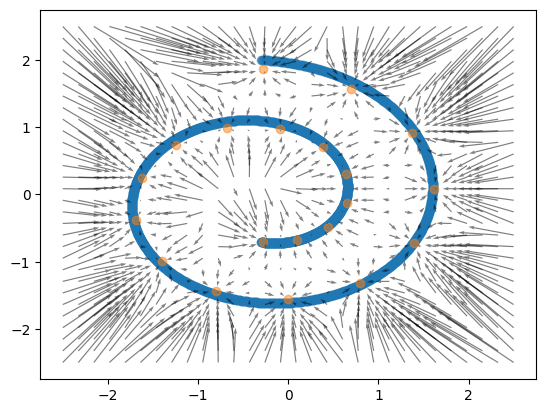

In [5]:
plt.scatter(*true_dist.T, alpha=0.5)
plt.scatter(*dataset.T, alpha=0.5)

# use solution code
grid = get_grid(nx=30,ny=30)
score = rbf_score(grid, dataset, sigma=0.2)
# plot_vectors(grid.view(-1,2), score.view(-1,2), scale=2)
plot_vectors(grid, score, scale=2)

## Sampling via the score function

Given our interpolated score function estimate $s_\sigma$, we can now implement a sampling scheme. Specifically, we examine annealed Langevin dynamics: given $x_0$ from an arbitrary initial distribution (e.g., uniform over a grid), we define an update rule

$$
x_t = x_{t-1} + \lambda_t s_{\sigma_t}(x_{t-1}) + \sqrt{2\lambda_t}\epsilon_{t}
$$

where $\epsilon_t \sim \mathcal{N}(0,I)$ is Gaussian noise and $\lambda_t$ is an iteration-dependent step size. We anneal by taking decreasing $\sigma_t$ as $t$ increases.

We will use
- a log-linear schedule for $\sigma^2$ in $[10^{-4}, 2\times 10^{-2}]$
- $\lambda_t$ given by
$$ \lambda_t = \frac{1-\alpha_t}{\sqrt{\alpha_t(1-\bar\alpha_t)}}$$ where $\alpha = 1 - \sigma^2$ and $\bar\alpha_t = \prod^{t}_{i=1}\alpha_i$

## Task 2: Implement annealed Langevin dynamics sampler

Implement the following function:

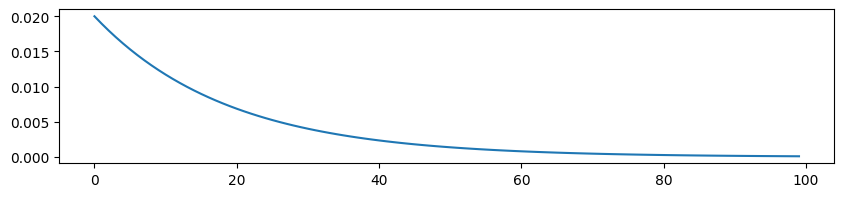

In [6]:
def log_linear_schedule(initial_value, final_value, steps):
  return torch.tensor(np.exp(np.linspace(np.log(initial_value), np.log(final_value), steps)))
fig, ax = plt.subplots(figsize=(10,2))
ax.plot(log_linear_schedule(2e-2, 1e-4, 100))

In [7]:
def sample(init_sample, score_function, n_steps, sigma_min=1e-4, sigma_max=2e-2, return_extra=False):
  """Samples from annealed Langevin dynamics for n_steps steps

  Params:
    init_sample: a tensor of shape (...,2) giving the initial data
    score_function: a function with two parameters, x and sigma, returning the estimated interpolated score function s_sigma(x)
    n_steps: the number of steps of of the dynamics to simulate
    sigma_min: minimum sigma value for annealing
    sigma_max: maximum sigma value for annealing

  Returns:
    a list of n_steps+1 tensors, whose entries are the results of the simulation starting from init_sample (first entry is init_sample)
  """
  n, d = init_sample.shape
  sigma_sq_t = log_linear_schedule(sigma_max, sigma_min, n_steps)
  alpha_t = 1-sigma_sq_t
  alpha_t_bar = alpha_t.cumprod(0)
  lambda_t = (1-alpha_t) / torch.sqrt(alpha_t*(1-alpha_t_bar))

  path = [init_sample]
  score_terms = []
  noise_terms = []
  for i in range(n_steps):
    score_term = lambda_t[i] * score_function(path[-1], sigma_sq_t[i]**.5)
    noise_term = torch.sqrt(2*lambda_t[i])*torch.randn((n,d))
    x_curr = path[-1] + score_term + noise_term
    path.append(x_curr)
    # save for plotting
    score_terms.append(score_term)
    noise_terms.append(noise_term)
  if return_extra:
    return path, score_terms, noise_terms, lambda_t
  return path

Visualize the results:

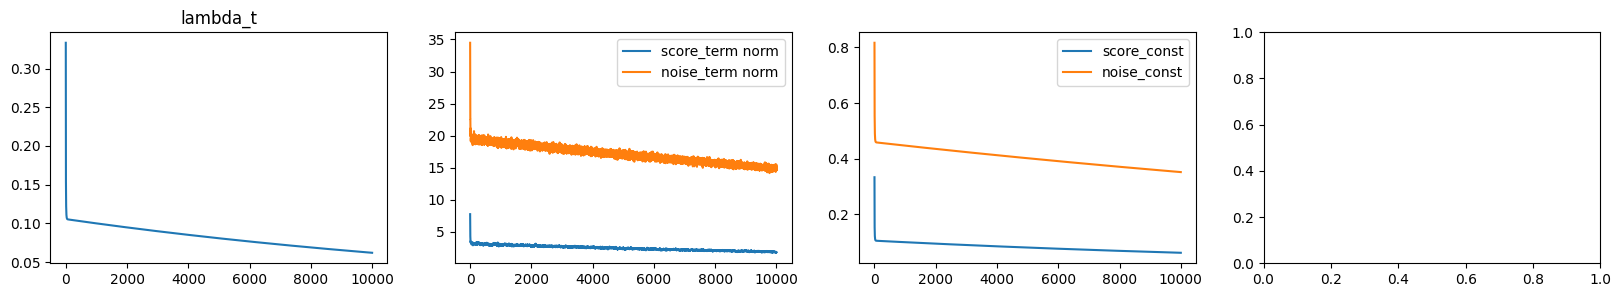

In [8]:
fig, axes = plt.subplots(1,4,figsize=(20,3))
path, score_terms, noise_terms, lambda_t = sample(grid, lambda x,sigma: rbf_score(x, dataset, sigma), n_steps=10000, sigma_min=0.06, sigma_max=0.1, return_extra=True)
axes[0].plot(lambda_t)
axes[0].set_title('lambda_t')
axes[1].plot(np.linalg.norm(score_terms,axis=(1,2)), label='score_term norm')
axes[1].plot(np.linalg.norm(noise_terms,axis=(1,2)), label='noise_term norm')
axes[1].legend()
axes[2].plot(lambda_t, label='score_const')
axes[2].plot(torch.sqrt(2*lambda_t), label='noise_const')
axes[2].legend()

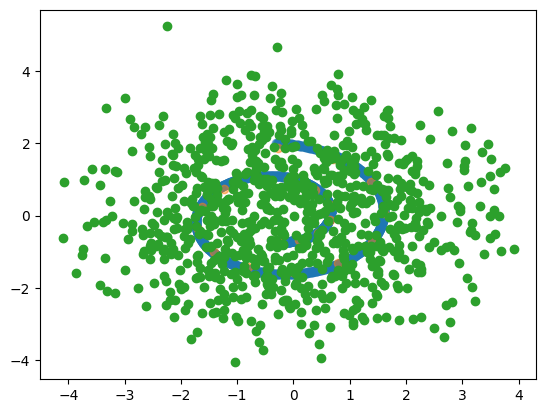

In [9]:
# path = sample(grid, lambda x,sigma: rbf_score(x, dataset, sigma), n_steps=1000, sigma_min=0.0001, sigma_max=0.02)
plt.scatter(*true_dist.T, alpha=0.5)
plt.scatter(*dataset.T, alpha=0.5)
plt.scatter(*path[-1].T)

# not really sure how to interpret the nans.  if a sample gets too far away it just vanishes as the score goes to infinity...

## Simplified score matching

Instead of using the explicit expression for the interpolated score function, we could attempt to learn a score function via a simplified version of denoising score matching. Given $x \sim \mathcal{D}$, we perturb it with Gaussian noise and learn to predict the original vector $x$ (or equivalently, the perturbation). That is, we can parameterize a model $f_\theta$ with parameters $\theta$, and optimize it according to the objective

$$ \min_\theta \mathbb{E}_{x,\epsilon,\sigma}\left[\|f_\theta(x+\sigma\epsilon, \sigma)-\sigma\epsilon\|^2_2\right] $$

Here, $x \sim \mathcal{D}$ and $\epsilon \sim \mathcal{N}(0,I)$ and $\sigma$ is drawn from a log-uniform distribution corresponding to the log-linear sampling schedule.

## Task 3: Training a neural network via score matching

Define a simple neural network architecture taking as inputs the noised samples $x+\sigma\epsilon$ and the noise rate $\sigma$, and predicting $\sigma\epsilon$. Train it by optimizing the simplified denoising score matching objective.

In [85]:
from torch import nn

class ResBlock(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.linear = nn.Linear(hidden_size,hidden_size)
        self.act = nn.GELU()
        
    def forward(self, x):
        return x+self.act(self.linear(x))
        

class NN(nn.Module):
    def __init__(self, hidden_size, timesteps, emb_dim):
        super().__init__()
        self.time_emb = nn.Embedding(timesteps, emb_dim)
                
        self.model = nn.Sequential(
            # 4 because we take in a sigma for each feature 
            nn.Linear(2+emb_dim, hidden_size),
            nn.GELU(),
            ResBlock(hidden_size),
            ResBlock(hidden_size),
            ResBlock(hidden_size),
            nn.Linear(hidden_size, 2)            
        )
        
    
    def forward(self, x, x_sigma, t):
        # x.shape (B,2)
        # x_sigma.shape (B,2)
        b,c = x.shape 

        time_emb = self.time_emb(t)
        x = torch.concat([x,time_emb],dim=1)
        
        out = self.model(x)
        noise = out * x_sigma
        
        return noise
        # return x + noise

In [118]:
# generate and plot spiral data
true_dist = spiral2d(N=2000)
dataset = spiral2d(N=1000)

In [119]:
from einops import rearrange
X = dataset
B = X.shape[0]

device = torch.device('cuda')
timesteps=200
sigma_sched = log_linear_schedule(1e-1, 1e-2, timesteps).to(torch.float32)
sigma_sched = torch.linspace(1e-1, 1e-2, timesteps, dtype=torch.float32)
init_lr = 3e-4
model = NN(hidden_size=256, timesteps=timesteps, emb_dim=32).to(device)
optim = torch.optim.AdamW(model.parameters(), lr=init_lr)

In [126]:
X.shape

torch.Size([200, 1000, 1, 2])

In [127]:
# generate data
n_trajectories_per_sample = 1
X_t = [dataset.unsqueeze(1).repeat(1,n_trajectories_per_sample,1)] # repeat along second axis
X_sigmas = []
X_noises = []
for sigma in reversed(sigma_sched):
    randn = torch.randn(X_t[-1].shape)
    X_t_now = X_t[-1] + (randn * sigma)
    X_sigmas.append(sigma.repeat(randn.shape))
    X_noises.append(randn * sigma)
    X_t.append(X_t_now)

X = torch.stack(X_t[1:], 0) # T,B,N,C
X_sigmas = torch.stack(X_sigmas, 0) # T,B,N,C
X_noises = torch.stack(X_noises, 0) # T,B,N,C
T,B,N,C = X.shape
# times = torch.arange(T)

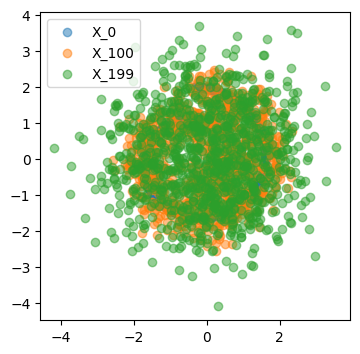

In [128]:
fig,ax=plt.subplots(1,1,figsize=(4,4))
for s in [0,100,199]:
    X_ = rearrange(X, 't b n c -> (b n) t c')
    ax.scatter(X_[:,s,0],X_[:,s,1], label=f'X_{s}',alpha=.5)
ax.legend()

In [129]:
B,T,N

(1000, 200, 1)

In [ ]:
X.shap

In [134]:
n_steps = 50000
batch_size = 4096
# N = X.shape[:3].numel()
for step in range(n_steps):
    # ix = torch.randint(low=0,high=N,size=(batch_size,))

    # might have some duplicates in the batch, but whatever
    b = torch.randint(low=0,high=B,size=(batch_size,))
    t = torch.randint(low=0,high=T,size=(batch_size,))
    n = torch.randint(low=0,high=N,size=(batch_size,))
    
    
    X_ = X[t,b,n].to(device)
    X_sigmas_ = X_sigmas[t,b,n].to(device)
    X_noises_ = X_noises[t,b,n].to(device)
    
    lr = init_lr # - (step/n_steps) * init_lr
    
    preds = model(X_, X_sigmas_, t.to(device))
    # 1/sigma_sched to weigh the small sigmas as much as the large
    dist = (preds - X_noises_)**2

    # weigh loss by sigma sched value
    # # weights = 1/sigma_sched
    # loss = dist * rearrange(weights, 's -> 1 s 1')
    # loss = loss.mean()
    loss = dist.mean()
    acc = (torch.sign(preds) == torch.sign(X_noises_)).to(float).mean()

    if step%500 == 0:
        print(f'{step}: {loss:.8f} lr={lr:.6f} acc = {acc:.2f}')

    optim.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optim.step()
    # break
    

0: 0.00397066 lr=0.000300 acc = 0.51
500: 0.00379086 lr=0.000300 acc = 0.51
1000: 0.00372751 lr=0.000300 acc = 0.52
1500: 0.00358266 lr=0.000300 acc = 0.53
2000: 0.00383165 lr=0.000300 acc = 0.52
2500: 0.00361492 lr=0.000300 acc = 0.52
3000: 0.00366357 lr=0.000300 acc = 0.53
3500: 0.00370685 lr=0.000300 acc = 0.51
4000: 0.00370542 lr=0.000300 acc = 0.52
4500: 0.00367694 lr=0.000300 acc = 0.53
5000: 0.00365698 lr=0.000300 acc = 0.53
5500: 0.00369760 lr=0.000300 acc = 0.52
6000: 0.00371014 lr=0.000300 acc = 0.52
6500: 0.00374352 lr=0.000300 acc = 0.52
7000: 0.00347037 lr=0.000300 acc = 0.54
7500: 0.00366670 lr=0.000300 acc = 0.52
8000: 0.00376966 lr=0.000300 acc = 0.53
8500: 0.00363183 lr=0.000300 acc = 0.53
9000: 0.00362535 lr=0.000300 acc = 0.53
9500: 0.00377890 lr=0.000300 acc = 0.53
10000: 0.00360872 lr=0.000300 acc = 0.53
10500: 0.00358782 lr=0.000300 acc = 0.54
11000: 0.00344805 lr=0.000300 acc = 0.54
11500: 0.00353940 lr=0.000300 acc = 0.54
12000: 0.00357201 lr=0.000300 acc = 0.54

KeyboardInterrupt: 

In [131]:
X.shape

torch.Size([200, 1000, 1, 2])

In [132]:
B

1000

In [124]:
b,t,n

(tensor([ 33,  55, 949,  ..., 268, 405,  85]),
 tensor([ 64,  13,  10,  ..., 191,   5, 116]),
 tensor([0, 0, 0,  ..., 0, 0, 0]))

In [98]:
t[:, None].shape

torch.Size([4096, 1])

In [99]:
torch.cat([preds[:5], X_noises_[:5], t[:5, None].to(device)], 1)

tensor([[-3.0978e-03,  2.5513e-02, -9.2186e-03,  1.6940e-02,  1.5100e+02],
        [ 1.0850e-02,  1.3484e-02, -4.7519e-02, -2.1546e-02,  1.4300e+02],
        [ 5.1032e-03, -4.2119e-02,  2.2533e-03, -1.8527e-01,  1.3000e+02],
        [ 5.6162e-03,  9.7424e-03,  2.9859e-02,  6.5030e-02,  1.3700e+02],
        [-9.2754e-03, -1.3103e-02, -1.6175e-02, -3.2360e-02,  1.6000e+01]],
       device='cuda:0', grad_fn=<CatBackward0>)

In [100]:
# # check preds vs labels
# i=2
# for j in [1,5,10,15,30,50,80,95]:
#     c = torch.stack([preds[i][j], 
#                      noises[i][j]]).cpu().detach()
#     print(j, c)

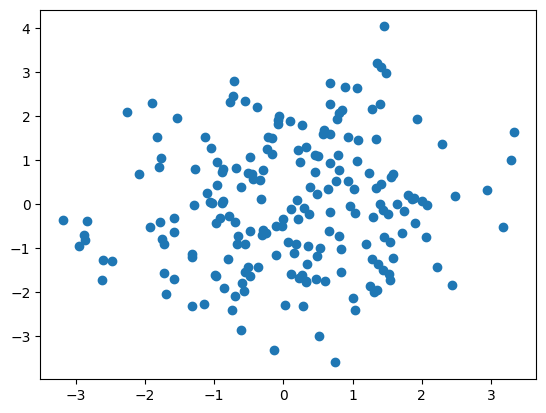

In [101]:
plt.scatter(X[-1,:,0,0],X[-1,:,0,1])

In [102]:
# list(range(100))

In [105]:
timesteps=200

In [106]:
from einops import repeat
# now let's denoise!
# X = torch.randn(10,2).to(torch.float32)
# B = X.shape[0]
# denoise the grid!

# X_t = grid.clone().to(torch.float32).to(device)
# X_t = rearrange(X_t, 'b c -> b 1 c')
# X_ts = [X_t]

X_t = X[-1,:,0].to(device)
X_ts = [X_t]
with torch.inference_mode():
    for t in range(timesteps):
        sigma = sigma_sched[t].unsqueeze(0).to(device).to(torch.float32)
        preds = model(X_t, sigma, torch.tensor([t]*X_t.shape[0]).to(device))
        X_t = X_t - preds
        X_ts.append(X_t)

In [107]:
timesteps

200

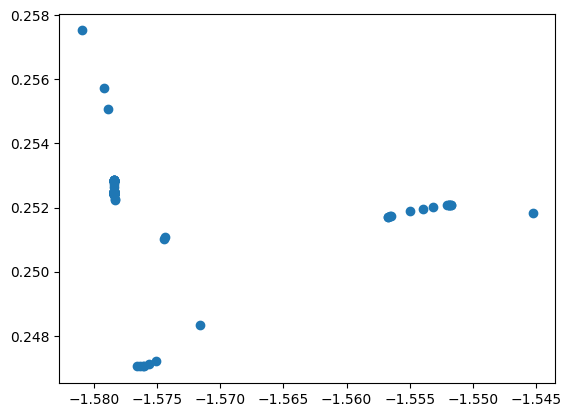

In [117]:
t=99
plt.scatter(X_ts[t][:,0].cpu(), X_ts[t][:,1].cpu())